# Data Preparation

## Pre-processing

In [74]:
from sklearn import metrics as mt
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [122]:
import numpy as np
import pandas as pd
import json
import re
from sklearn.preprocessing import LabelEncoder, LabelBinarizer


df = pd.read_csv('movies_metadata.csv')

print(len(df),'items in unprocessed dataframe')
df = df[df.status=='Released']
df = df[df.original_language=='en']
df = df.drop(columns=['adult','belongs_to_collection','homepage','imdb_id','original_language','overview',
                     'poster_path','release_date','spoken_languages',
                     'status','tagline','video','original_title'])

def contains_us(row):
    return 'US' in row

def get_genres(row):
    s = re.findall("'name': '(.*?)'",row)
    if len(s) > 0:
        return s
    else:
        return None

def get_prod_companies(row):

    s = re.findall("{'name': '(.*?)'",row)
    '''
    if len(s) > 0:
        return s
    else:
        return None
    '''
    if len(s) > 1:
        return 'Collaboration'
    elif len(s) == 1:
        return s[0]
    else:
        return None

def discretize_runtime(row):
    if row < 40:
        return 'Short Film'
    elif row < 80:
        return 'Less than Feature Film'
    elif row < 130:
        return 'Below Average Feature Film'
    else:
        return 'Above Average Feature Film'

df['made_in_us'] = df.production_countries.apply(contains_us)
df = df.drop(columns=['production_countries'])
df['production_companies'] = df.production_companies.apply(get_prod_companies)

df['genres'] = df.genres.apply(get_genres)

df = df.dropna()
enc = LabelEncoder()
df['production_companies_int'] = enc.fit_transform(df.production_companies)

df['runtime_category'] = df.runtime.apply(discretize_runtime)
df['runtime_category_int'] = enc.fit_transform(df.runtime_category)

df['budget'] = df.budget.apply(float)
df['popularity'] = df.popularity.apply(float)
df['id'] = df.id.apply(int)


avg = df.vote_average.mean()
df['above_average_vote'] = df.vote_average > avg
for x in df['genres']:
    x.sort()
df['genres_int'] = enc.fit_transform(df.genres)
df['genres'] = df['genres'].apply("_".join)


print(max(df.production_companies_int)+1,'classes for production_companies')
print(max(df.genres_int)+1,'classes for genres')

print(len(df),'items in processed dataframe\n')
print(list(df))
print(df.dtypes)
categorical_headers_ints = ['production_companies_int','genres_int','runtime_category_int']
numeric_headers = ['budget','popularity','revenue','runtime','vote_average','vote_count']

c:\users\momin\envs\ml_lab1\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


45466 items in unprocessed dataframe
4572 classes for production_companies
1441 classes for genres
23298 items in processed dataframe

['budget', 'genres', 'id', 'popularity', 'production_companies', 'revenue', 'runtime', 'title', 'vote_average', 'vote_count', 'made_in_us', 'production_companies_int', 'runtime_category', 'runtime_category_int', 'above_average_vote', 'genres_int']
budget                      float64
genres                       object
id                            int64
popularity                  float64
production_companies         object
revenue                     float64
runtime                     float64
title                        object
vote_average                float64
vote_count                  float64
made_in_us                     bool
production_companies_int      int64
runtime_category             object
runtime_category_int          int64
above_average_vote             bool
genres_int                    int64
dtype: object


In [76]:
print(df.vote_average.quantile([.25,.5,.75,.9,.99,1]))
print(len(df[df.vote_count>0]))

0.25     5.1
0.50     6.0
0.75     6.7
0.90     7.3
0.99     8.3
1.00    10.0
Name: vote_average, dtype: float64
22449


In this lab, we work with the Kaggle Movies Dataset. This dataset contains metadata on 45,466 different movies released on or before July 2017. The dataset includes information about each movie such as the budget, the genres, the runtime, the revenue, and popularity scores based on data from the research group GroupLens.

In preprocessing the data, we first remove the features we will not be using for classification. Then, we create a few new columns.

First, we create a column called made_in_us. This is a modification of the original column production_countries, which contains a list of the countries each movie was produced in. Since there were a large number of such countries, we chose to represent that column as a binary value of if this movie was produced in the United States or in a different country.

Next, we create a column called production_companies_int. This is a modification of the original column production_companies, which contains a list of the production companies that created each movie. We take this list of production companies and represent collaborations between multiple production companies as the class "collaboration" - we do this because there is a large number of combinations otherwise. Then, we encode the production company as an integer using sklearn's LabelEncoder class.

Next, we create a column called genres_int. This is a modification of the original column genres, which contains a list of the genres each movie belongs to. We take this list of genres and encode it using sklearn's LabelEncoder class. In the case that there are multiple genres for a movie, such as a romantic comedy, we represent this combination as its own class, unlike with the production companies. The rationale behind this choice is that there is a much larger number of production companies than genres - we can represent all combinations of genres with 2,970 classes. 

Next, we create a column called above_average_vote. This is a modification of the original column average_vote, which is the average of all votes given to this movie on a scale of 0-10. This column is the target column; we will try to predict if a movie can score above average.

Finally, we create a column called runtime_category_int. This is a modification of the original column runtime, which is the runtime of the movie in minutes. We discretize the runtime into 4 categories: short film, less than feature film, below average feature film, and above average feature film. We use the following cutoffs: a short film is less than 40 minutes, a movie that is less than a feature film is less than 80 minutes, a feature film below average is less than 130 minutes, and a feature film above average is longer than 130 minutes. 

We derive the runtime of a short film from the rules the Oscar awards establish for the short film category (http://www.oscars.org/sites/oscars/files/90aa_short_films.pdf). We derive the length of a feature film from the Screen Actor's Guild (http://www.sagaftra.org/files/sag/Low_Budget_Ageement_1_5.pdf). We derive the average length of a feature film from a Business Insider study (http://www.businessinsider.com/movies-are-getting-longer-2013-1).

We choose to represent the runtime category as categorical data and not ordinal data. The reason we represent runtime categorically instead of ordinally is because different categories of film are not necessarily similar to one another. For example, below average feature films are closer in length to short films than above average feature films are. However, since short films are often not shown in movie theatres, it is likely that there is an entirely different audience for short films than there is for below average length feature films.

## Crossing Features

### Train Test Split

In [123]:
from sklearn.model_selection import StratifiedKFold
from copy import deepcopy

df_features = ['budget', 'genres', 'id', 'popularity', 'production_companies', 'revenue', 
               'runtime', 'title', 'vote_average', 'vote_count', 'made_in_us', 'production_companies_int', 
               'runtime_category', 'runtime_category_int', 'genres_int']
df_class = ['above_average_vote']

skf = StratifiedKFold(n_splits = 10)

X = df[df_features]
y = df[df_class]
## Comparison to MLP


precisions_MLP=[]
for train,test in zip(train_list[0:3],test_list[0:3]):
    df_train = deepcopy(df.iloc[train])
    df_test = deepcopy(df.iloc[test])
    
    ohe = OneHotEncoder()
    X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
    X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

    y_train = df_train[df_class].values.astype(np.int)
    y_test = df_test[df_class].values.astype(np.int)
    
    inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
    xSparse = Dense(units=10, activation='relu', name='ohe_1')(inputsSparse)

    # create dense input branch for numeric
    inputsDense = Input(shape=(X_train_num.shape[1],),sparse=False, name='X_Numeric')
    xDense = Dense(units=10, activation='relu',name='num_1')(inputsDense)

    x = concatenate([xSparse, xDense], name='concat')
    predictions = Dense(1,activation='sigmoid', name='combined')(x)

    # This creates a model that includes
    # the Input layer and Dense layers
    model = Model(inputs=[inputsSparse,inputsDense], outputs=predictions)

    model.compile(optimizer='sgd',
                  loss='mean_squared_error',
                  metrics=['accuracy', precision])
    model.fit([ X_train_ohe, X_train_num ], # inputs for each branch are a list
              y_train, 
              epochs=10, 
              batch_size=50, 
              verbose=0)

    yhat = model.predict([X_test_ohe,
                          X_test_num]) # each branch has an input

    yhat = np.round(yhat)
    precisions_MLP.append(mt.precision_score(y_test,yhat))

    

print(precisions_MLP)
print([x.history['val_precision'][-1] for x in histories1])
hist = [x.history['val_precision'][-1] for x in histories1]
plt.scatter([x for x in range(1,4)],precisions_MLP, label='MLP')
plt.scatter([x for x in range(1,4)], hist,label='Wide & Deep')
plt.legend()
plt.xlabel('Fold number')
plt.ylabel('Precision %')
train_list = []
test_list = []

for train_index, test_index in skf.split(X, y):
    train_list.append(train_index)
    test_list.append(test_index)


df_train = deepcopy(df.iloc[train_list[0]])
df_test = deepcopy(df.iloc[test_list[0]])

### ONE HOT ENCODING ONLY MODEL

In [78]:
from sklearn.preprocessing import OneHotEncoder

# now let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

y_train = df_train[df_class].values.astype(np.int)
y_test = df_test[df_class].values.astype(np.int)

# the ohe instance will help us to organize our encoded matrix
print(ohe.feature_indices_)
print(X_train_ohe.shape)

[   0 4572 6013 6017]
(20967, 5795)


In [79]:
# combine the features with two branches

# let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

# and save off the numeric features
X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values

# create sparse input branch for ohe
inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
xSparse = Dense(units=10, activation='relu', name='ohe_1')(inputsSparse)

# create dense input branch for numeric
inputsDense = Input(shape=(X_train_num.shape[1],),sparse=False, name='X_Numeric')
xDense = Dense(units=10, activation='relu',name='num_1')(inputsDense)

x = concatenate([xSparse, xDense], name='concat')
predictions = Dense(1,activation='sigmoid', name='combined')(x)

# This creates a model that includes
# the Input layer and Dense layers
model = Model(inputs=[inputsSparse,inputsDense], outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_ohe (InputLayer)              (None, 5795)         0                                            
__________________________________________________________________________________________________
X_Numeric (InputLayer)          (None, 6)            0                                            
__________________________________________________________________________________________________
ohe_1 (Dense)                   (None, 10)           57960       X_ohe[0][0]                      
__________________________________________________________________________________________________
num_1 (Dense)                   (None, 10)           70          X_Numeric[0][0]                  
__________________________________________________________________________________________________
concat (Co

In [80]:
#cell to define precision metric
import keras.backend as K
#precision metric gotten from previous release of keras
#https://github.com/keras-team/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [81]:
%%time


model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy', precision])
model.fit([ X_train_ohe, X_train_num ], # inputs for each branch are a list
          y_train, 
          epochs=5, 
          batch_size=50, 
          verbose=0)

yhat = model.predict([X_test_ohe,
                      X_test_num]) # each branch has an input

yhat = np.round(yhat)
print(mt.confusion_matrix(y_test,yhat),mt.precision_score(y_test,yhat))

[[527 381]
 [764 659]] 0.6336538461538461
Wall time: 8.17 s


## Wide and Deep Model

In [82]:

#genres_int and runtime_category_int, as well as the values for genres_int and made_in_us_int.
cross_columns = [['genres','runtime_category'],
                 ['genres','made_in_us']]

#'workclass','education','marital_status','occupation','relationship','race','sex','country'

# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    print (df_train[cols].head())
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(str(x)), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(str(x)), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )


# let's encode the integer outputs as one hot encoded labels
#ohe = OneHotEncoder()
#X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
#X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

# create sparse input branch for ohe
#inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
#sparse_branch = Dense(units=20, activation='relu', name='ohe_1')(inputsSparse)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
drop_out_deep = Dropout(0.10)(deep_branch) 
deep_branch = Dense(units=50,activation='relu', name='deep1')(drop_out_deep)
drop_out_deep = Dropout(0.10)(deep_branch) 
deep_branch = Dense(units=25,activation='relu', name='deep2')(drop_out_deep)
drop_out_deep = Dropout(0.10)(deep_branch) 
deep_branch = Dense(units=10,activation='relu', name='deep3')(drop_out_deep)
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)


                      genres            runtime_category
2346                  Horror  Below Average Feature Film
2347                  Horror  Below Average Feature Film
2350                  Comedy  Below Average Feature Film
2352  Horror_Science Fiction  Below Average Feature Film
2354  Drama_Mystery_Thriller  Above Average Feature Film
                      genres  made_in_us
2346                  Horror        True
2347                  Horror        True
2350                  Comedy        True
2352  Horror_Science Fiction        True
2354  Drama_Mystery_Thriller       False


In [83]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy', precision])
initial_weights = model.get_weights()
# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=5, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))

Train on 20967 samples, validate on 2331 samples
Epoch 1/5
20967/20967 [==============================] - 69s 3ms/step - loss: 0.2766 - acc: 0.6028 - precision: 0.6273 - val_loss: 0.2995 - val_acc: 0.6323 - val_precision: 0.6198
Epoch 2/5
20967/20967 [==============================] - 71s 3ms/step - loss: 0.2517 - acc: 0.6532 - precision: 0.6539 - val_loss: 0.2915 - val_acc: 0.6680 - val_precision: 0.6335
Epoch 3/5
20967/20967 [==============================] - 69s 3ms/step - loss: 0.2146 - acc: 0.7488 - precision: 0.7301 - val_loss: 0.2852 - val_acc: 0.6903 - val_precision: 0.6440
Epoch 4/5
20967/20967 [==============================] - 68s 3ms/step - loss: 0.1982 - acc: 0.7973 - precision: 0.7797 - val_loss: 0.2813 - val_acc: 0.7027 - val_precision: 0.6495
Epoch 5/5
20967/20967 [==============================] - 70s 3ms/step - loss: 0.1779 - acc: 0.8298 - precision: 0.8032 - val_loss: 0.2790 - val_acc: 0.7057 - val_precision: 0.6521
Wall time: 5min 47s


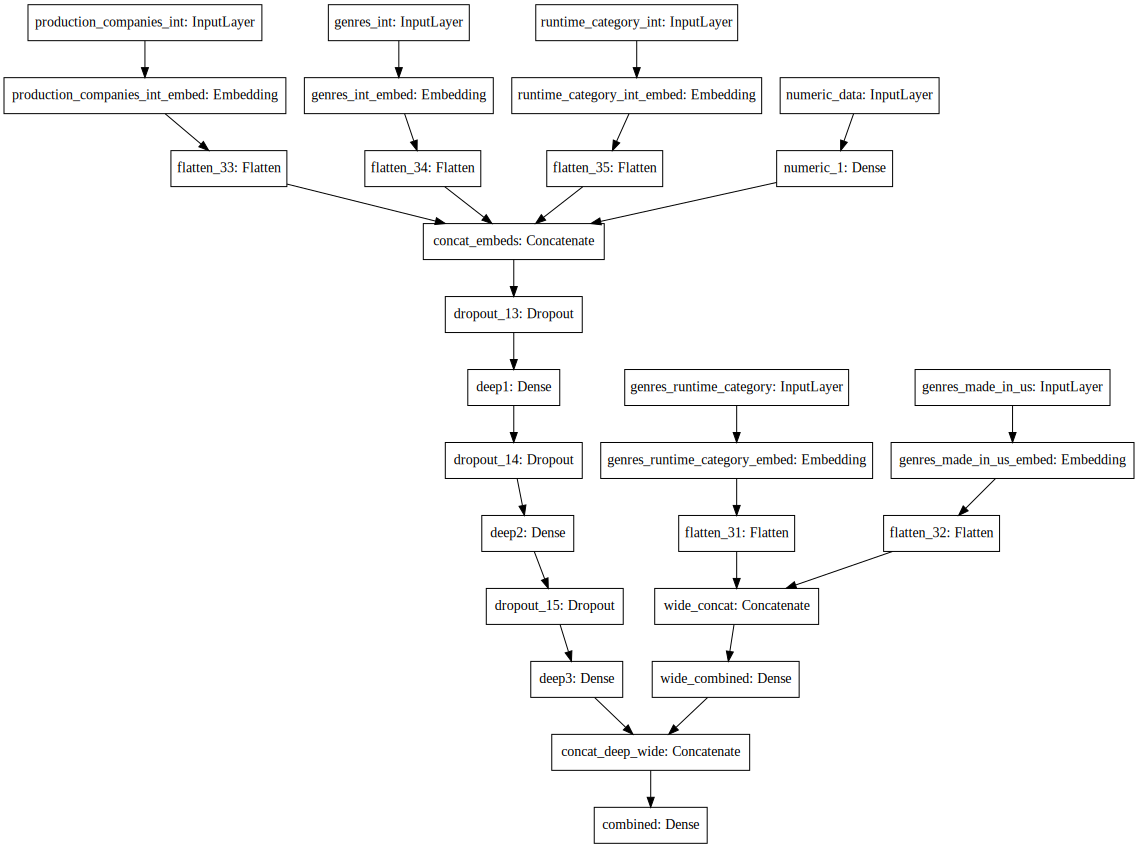

In [37]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [84]:
yhat = np.round(model.predict(X_ints_test + [X_test_num]))
print(mt.confusion_matrix(y_test,yhat), mt.precision_score(y_test,yhat))

[[ 273  635]
 [  51 1372]] 0.6836073741903338


Text(0.5,0,'epochs')

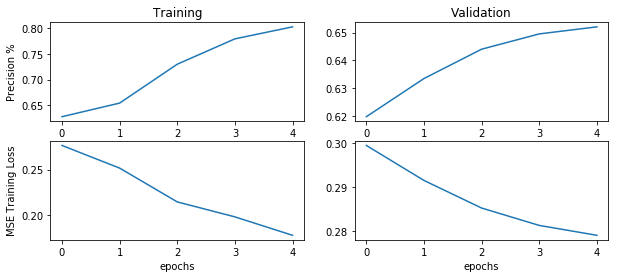

In [85]:
from matplotlib import pyplot as plt

%matplotlib inline
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

After preprocessing, we create cross-product features for the wide part of our wide-and-deep network. We cross the values for genres_int and runtime_category_int, as well as the values for genres_int and made_in_us_int.

We decide to cross the values for genres_int and runtime_category_int because films of different genres often have different lengths. For example, action movies have an average runtime of 100.46 minutes, whereas animation movies have an average runtime of 61.04 minutes. Thus, we speculate that a long animation movie will have a different reaction than a long action movie.

Next, we cross the values for genres_int and made_in_us int. We base this feature cross on the idea that different countries may prefer different genres of movie. This hypothesis is supported by independent research from the New York Film Academy (https://www.nyfa.edu/student-resources/12-of-the-most-popular-movie-genres-by-country/) and the American Film Market & Conferences association (http://americanfilmmarket.com/relative-popularity-genres-around-world/).

## Evaluation metric

Our chosen task is a binary classification task: can we predict if a movie will score above or below average when rated by users on a scale of 0-10? We found in our data set that the average of the ~22,000 movies reviewed is a 6.0/10; therefore, a movie that scores above 6.0 is above average, any a movie scoring 6.0 or less is not.

The business case for our prediction task is a movie studio trying to determine if their next movie will score above average or not. We imagine that a movie studio would come to us for our analysis after defining the basic criteria for their movie, such as genre, budget, and approximate runtime. At this point in the production cycle, the firm has not yet invested large amounts of time or money into creating the movie outline. Thus, the movie studio would much rather us reject a good idea than accept a bad idea; a rejected good idea is a waste of the small amount of time put into creating a movie outline, but an accepted bad idea will waste future resources as well as the outline time.

With this use case in mind, we advance precision as our chosen evaluation criteria. Precision, mathematically defined as tp/(tp+fp), is a measure of what percentage of named positives are true positives. In our use case, a precision score of 30% means that, of the movies we said would do better than average, only 30% actually did better than average.

The movie studio would be interested in a high-precision system because this system is good at telling if a movie will be above average. A 90% precision score means that 9 out of 10 movies that we say will succeed do in fact succeed; this goves the movie studio an idea of how likely it is that their movie is a winner.

## Train/test split

For this lab, we will use a 10-fold stratified cross-validation approach for splitting our data into training and testing sets. The reason we use cross-validation instead of shuffle-split is that we worry we do not have enough data. After pre-processing, we are left with ~22,000 movies. This is not an entirely small dataset; however, the feature space is quite large. For example, the movie genre alone can take on 2,970 different values, and the production company 4,572 values. We use 10-folds so that 90% of our data comprises the training set in each fold; this will ensure to the best of our ability that we have enough data.

The reason we use stratified cross-validation is to preserve the class distributions seen in the data; if one class of a feature occurs 10% of the time in the data, it will occur 10% of the time in the training data and 10% of the time in the testing data. We use stratified cross-validation because our data represent the real-world distribution. When applied to real movies, it will also be true that there is large class imbalance in certain features; it is unlikely that in the future a dramatically different percentage of the market will be dominated by Animated-Romantic-Action-Adult films.

In [90]:
#genres_int and runtime_category_int, as well as the values for genres_int and made_in_us_int.
cross_columns = [['genres','runtime_category'],
                     ['genres','made_in_us']]

X = df[df_features]
y = df[df_class]
histories1=[]
histories2=[]
for train,test in zip(train_list[0:5:2],test_list[0:5:2]):
    print("Testing on", len(histories1)+1, "split")
    df_train = deepcopy(df.iloc[train])
    df_test = deepcopy(df.iloc[test])
    ohe = OneHotEncoder()
    X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
    X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

    y_train = df_train[df_class].values.astype(np.int)
    y_test = df_test[df_class].values.astype(np.int)
    # and save off the numeric features
    X_train_num =  df_train[numeric_headers].values
    X_test_num = df_test[numeric_headers].values
    #'workclass','education','marital_status','occupation','relationship','race','sex','country'

    # we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(str(x)), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(str(x)), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    drop_out_deep = Dropout(0.10)(deep_branch) 
    deep_branch = Dense(units=50,activation='relu', name='deep1')(drop_out_deep)
    drop_out_deep = Dropout(0.10)(deep_branch) 
    deep_branch = Dense(units=25,activation='relu', name='deep2')(drop_out_deep)
    final_branch1 = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch1 = Dense(units=1,activation='sigmoid',name='combined')(final_branch1)

    model1 = Model(inputs=all_inputs, outputs=final_branch1)
    model1.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  metrics=['accuracy', precision])
    history1 = model1.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=5, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))
    histories1.append(history1)
    

Testing on 1 split
Train on 20967 samples, validate on 2331 samples
Epoch 1/5
20967/20967 [==============================] - 68s 3ms/step - loss: 0.3539 - acc: 0.5768 - precision: 0.6860 - val_loss: 0.4799 - val_acc: 0.4951 - val_precision: 0.6549
Epoch 2/5
20967/20967 [==============================] - 69s 3ms/step - loss: 0.3195 - acc: 0.6275 - precision: 0.7538 - val_loss: 0.4730 - val_acc: 0.5071 - val_precision: 0.6732
Epoch 3/5
20967/20967 [==============================] - 70s 3ms/step - loss: 0.2914 - acc: 0.6748 - precision: 0.8059 - val_loss: 0.2779 - val_acc: 0.7040 - val_precision: 0.6737
Epoch 4/5
20967/20967 [==============================] - 71s 3ms/step - loss: 0.2141 - acc: 0.7639 - precision: 0.8231 - val_loss: 0.3477 - val_acc: 0.6255 - val_precision: 0.6846
Epoch 5/5
20967/20967 [==============================] - 67s 3ms/step - loss: 0.2345 - acc: 0.7530 - precision: 0.8620 - val_loss: 0.4687 - val_acc: 0.5127 - val_precision: 0.7234
Testing on 2 split
Train on 2096

In [91]:
for train,test in zip(train_list[0:5:2],test_list[0:5:2]):
    print("Testing on", len(histories2)+1, "split")
    df_train = deepcopy(df.iloc[train])
    df_test = deepcopy(df.iloc[test])
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
    X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

    y_train = df_train[df_class].values.astype(np.int)
    y_test = df_test[df_class].values.astype(np.int)
    # and save off the numeric features
    X_train_num =  df_train[numeric_headers].values
    X_test_num = df_test[numeric_headers].values
    #'workclass','education','marital_status','occupation','relationship','race','sex','country'

    # we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(str(x)), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(str(x)), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )


    # let's encode the integer outputs as one hot encoded labels
    #ohe = OneHotEncoder()
    #X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
    #X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

    # create sparse input branch for ohe
    #inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
    #sparse_branch = Dense(units=20, activation='relu', name='ohe_1')(inputsSparse)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    drop_out_deep = Dropout(0.10)(deep_branch) 
    deep_branch = Dense(units=50,activation='relu', name='deep1')(drop_out_deep)
    drop_out_deep = Dropout(0.10)(deep_branch) 
    deep_branch = Dense(units=25,activation='relu', name='deep2')(drop_out_deep)

    drop_out_deep = Dropout(0.10)(deep_branch) 
    deep_branch = Dense(units=10,activation='relu', name='deep3')(drop_out_deep)

    final_branch2 = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch2 = Dense(units=1,activation='sigmoid',name='combined')(final_branch2)

    model2 = Model(inputs=all_inputs, outputs=final_branch2)
    model2.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  metrics=['accuracy', precision])
    history2 = model2.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=5, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))
    histories2.append(history2)
    

Testing on 1 split
Train on 20967 samples, validate on 2331 samples
Epoch 1/5
20967/20967 [==============================] - 63s 3ms/step - loss: 0.2675 - acc: 0.6317 - precision: 0.6487 - val_loss: 0.2930 - val_acc: 0.6461 - val_precision: 0.6268
Epoch 2/5
20967/20967 [==============================] - 61s 3ms/step - loss: 0.2375 - acc: 0.6912 - precision: 0.6898 - val_loss: 0.2895 - val_acc: 0.6607 - val_precision: 0.6308
Epoch 3/5
20967/20967 [==============================] - 62s 3ms/step - loss: 0.1993 - acc: 0.7687 - precision: 0.7540 - val_loss: 0.2834 - val_acc: 0.6808 - val_precision: 0.6366
Epoch 4/5
20967/20967 [==============================] - 59s 3ms/step - loss: 0.1775 - acc: 0.8164 - precision: 0.7976 - val_loss: 0.2778 - val_acc: 0.7036 - val_precision: 0.6479
Epoch 5/5
20967/20967 [==============================] - 62s 3ms/step - loss: 0.1656 - acc: 0.8363 - precision: 0.8187 - val_loss: 0.2733 - val_acc: 0.7181 - val_precision: 0.6537
Testing on 2 split
Train on 2096

In [97]:
import seaborn as sns
%matplotlib inline

precisions1 = [x.history['val_precision'][-1] for x in histories1]
precisions2 = [x.history['val_precision'][-1] for x in histories2]

print(np.mean(precisions1), np.mean(precisions2))

0.6491572519553537 0.6263475307205343


Text(0,0.5,'Precision %')

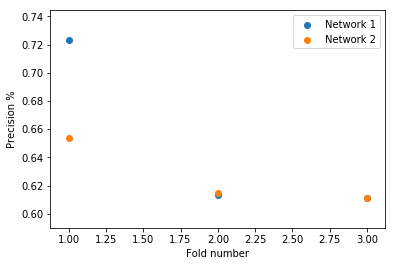

In [98]:
plt.scatter([x for x in range(1,4)], precisions1, label='Network 1')
plt.scatter([x for x in range(1,4)], precisions2,label='Network 2')
plt.legend()
plt.xlabel('Fold number')
plt.ylabel('Precision %')

We can see that on average, our first and second network perform very closely to one another, although Network 2 seems to be more consistent over the first 3 folds we validated on. In the block below, we look at the average precision based on every epoch and training/test fold. Since each epoch is expensive, that average could give us insight as to which network would perform better without much training. We could not afford to run 3 epochs on all 10 KFolds as it was a very expensive operation and we do not own the hardware needed to  We see that Network 1 performed better overall and decide to use as our 

In [99]:
precisions1 = [x.history['val_precision'] for x in histories1]
precisions2 = [x.history['val_precision'] for x in histories2]

print(np.mean(precisions1), np.mean(precisions2))

0.6350410277963655 0.621217282277813


## Comparison to MLP

In [27]:

precisions_MLP=[]
for train,test in zip(train_list[0:3],test_list[0:3]):
    df_train = deepcopy(df.iloc[train])
    df_test = deepcopy(df.iloc[test])
    
    ohe = OneHotEncoder()
    X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
    X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

    y_train = df_train[df_class].values.astype(np.int)
    y_test = df_test[df_class].values.astype(np.int)
    
    inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
    xSparse = Dense(units=10, activation='relu', name='ohe_1')(inputsSparse)

    # create dense input branch for numeric
    inputsDense = Input(shape=(X_train_num.shape[1],),sparse=False, name='X_Numeric')
    xDense = Dense(units=10, activation='relu',name='num_1')(inputsDense)

    x = concatenate([xSparse, xDense], name='concat')
    predictions = Dense(1,activation='sigmoid', name='combined')(x)

    # This creates a model that includes
    # the Input layer and Dense layers
    model = Model(inputs=[inputsSparse,inputsDense], outputs=predictions)

    model.compile(optimizer='sgd',
                  loss='mean_squared_error',
                  metrics=['accuracy', precision])
    model.fit([ X_train_ohe, X_train_num ], # inputs for each branch are a list
              y_train, 
              epochs=10, 
              batch_size=50, 
              verbose=0)

    yhat = model.predict([X_test_ohe,
                          X_test_num]) # each branch has an input

    yhat = np.round(yhat)
    precisions_MLP.append(mt.precision_score(y_test,yhat))

    

[0.5954598370197904, 0.6433301797540208, 0.6727722772277228]
[0.6589720079899857, 0.6187309109054886, 0.6123887859460675]


Text(0,0.5,'Precision %')

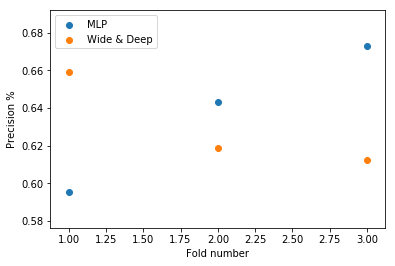

In [29]:
print(precisions_MLP)
print([x.history['val_precision'][-1] for x in histories1])
hist = [x.history['val_precision'][-1] for x in histories1]
plt.scatter([x for x in range(1,4)],precisions_MLP, label='MLP')
plt.scatter([x for x in range(1,4)], hist,label='Wide & Deep')
plt.legend()
plt.xlabel('Fold number')
plt.ylabel('Precision %')

In [124]:
from sklearn.model_selection import StratifiedKFold
from copy import deepcopy
import random

df_features = ['budget', 'genres', 'id', 'popularity', 'production_companies', 'revenue', 
               'runtime', 'title', 'vote_average', 'vote_count', 'made_in_us', 'production_companies_int', 
               'runtime_category', 'runtime_category_int', 'genres_int']
df_class = ['above_average_vote']

skf = StratifiedKFold(n_splits = 10)

X = df[df_features]
y = df[df_class]
train_list = []
test_list = []

for train_index, test_index in skf.split(X, y):
    train_list.append(train_index)
    test_list.append(test_index)

df_train = deepcopy(df.iloc[train_list[0]])
df_test = deepcopy(df.iloc[test_list[0]])

In [125]:
from sklearn.preprocessing import OneHotEncoder

#genres_int and runtime_category_int, as well as the values for genres_int and made_in_us_int.
cross_columns = [['genres','runtime_category'],
                     ['genres','made_in_us']]

X = df[df_features]
y = df[df_class]
histories1=[]
histories2=[]

for train,test in zip(train_list[0:5:2],test_list[0:5:2]):
    print("Testing on", len(histories1)+1, "split")
    df_train = deepcopy(df.iloc[train])
    
    for col in numeric_headers:
        col_vals = df_train[col]
        std = np.std(col_vals)
        random.seed(1)
        df_train[col] = col_vals.apply(lambda x: x + (random.random() * .5 * std))
    
    df_test = deepcopy(df.iloc[test])
    ohe = OneHotEncoder()
    X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
    X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

    y_train = df_train[df_class].values.astype(np.int)
    y_test = df_test[df_class].values.astype(np.int)
    # and save off the numeric features
    X_train_num =  df_train[numeric_headers].values
    X_test_num = df_test[numeric_headers].values
    #'workclass','education','marital_status','occupation','relationship','race','sex','country'

    # we need to create separate lists for each branch
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(str(x)), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(str(x)), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    # merge the branches together
    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

    # reset this input branch
    all_deep_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers_ints:
        # encode as ints for the embedding
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        # get the number of categories
        N = max(X_ints_train[-1]+1) # same as the max(df_train[col])

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    # also get a dense branch of the numeric features
    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))

    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )


    # let's encode the integer outputs as one hot encoded labels
    #ohe = OneHotEncoder()
    #X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
    #X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

    # create sparse input branch for ohe
    #inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
    #sparse_branch = Dense(units=20, activation='relu', name='ohe_1')(inputsSparse)


    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    drop_out_deep = Dropout(0.10)(deep_branch) 
    deep_branch = Dense(units=50,activation='relu', name='deep1')(drop_out_deep)
    drop_out_deep = Dropout(0.10)(deep_branch) 
    deep_branch = Dense(units=25,activation='relu', name='deep2')(drop_out_deep)
    final_branch1 = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch1 = Dense(units=1,activation='sigmoid',name='combined')(final_branch1)

    model1 = Model(inputs=all_inputs, outputs=final_branch1)
    model1.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  metrics=['accuracy', precision])
    history1 = model1.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=5, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))
    histories1.append(history1)
    

Testing on 1 split
Train on 20967 samples, validate on 2331 samples
Epoch 1/5
20967/20967 [==============================] - 67s 3ms/step - loss: 0.6105 - acc: 0.3895 - precision: 0.0015 - val_loss: 0.6102 - val_acc: 0.3895 - val_precision: 0.0000e+00
Epoch 2/5
20967/20967 [==============================] - 61s 3ms/step - loss: 0.6105 - acc: 0.3895 - precision: 0.0015 - val_loss: 0.6102 - val_acc: 0.3895 - val_precision: 0.0000e+00
Epoch 3/5
20967/20967 [==============================] - 63s 3ms/step - loss: 0.6104 - acc: 0.3896 - precision: 0.0061 - val_loss: 0.6102 - val_acc: 0.3895 - val_precision: 0.0000e+00
Epoch 4/5
20967/20967 [==============================] - 63s 3ms/step - loss: 0.6104 - acc: 0.3896 - precision: 0.0031 - val_loss: 0.6102 - val_acc: 0.3895 - val_precision: 0.0000e+00
Epoch 5/5
20967/20967 [==============================] - 63s 3ms/step - loss: 0.6106 - acc: 0.3894 - precision: 0.0015 - val_loss: 0.6102 - val_acc: 0.3895 - val_precision: 0.0000e+00
Testing on 2

Now with only puturbing the class variable slightly:

# TSNE Clustering

We perform t-SNE clustering of the weights in two of our OHE embedded layers to look for similarities between the separate classes of our Runtime Category and a subsample of our genres. We aim to prove that the Runtimes should have little to do with each other and be 4 completely separate classes, while the genres should get clustered together to other entries that have part of the same genre.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
weights=model1.get_layer(name='runtime_category_int_embed').get_weights()
weight_labels=['Short Film','Less than Feature Film','Below Average Feature Film','Above Average Feature Film']
tsne = TSNE(n_components=2, verbose=1)
transformed_weights = tsne.fit_transform(weights[0])
fig, ax = plt.subplots()
ax.scatter(transformed_weights[:,0], transformed_weights[:,1],lw=0, s=40)
for i, txt in enumerate(weight_labels):
    ax.annotate(txt, (transformed_weights[:,0][i], transformed_weights[:,1][i]))

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
weights=model1.get_layer(name='genres_int_embed').get_weights()
weight_labels=df['genres'].unique()[0:13]
tsne = TSNE(n_components=2, verbose=1)
transformed_weights = tsne.fit_transform(weights[0][0:13])
fig, ax = plt.subplots()
ax.scatter(transformed_weights[:,0], transformed_weights[:,1],lw=0, s=40)

for i, txt in enumerate(weight_labels):
    ax.annotate(txt, (transformed_weights[:,0][i], transformed_weights[:,1][i]))


We see from the two plots of the t-SNE clusters that the runtimes were indeed 4 separate classes. Some of the genres were close such as Comedy_Horror, Comedy_Romance, Comedy and Animation_Comedy_Family. Some of the "Action" genres were successfully grouped together. There are some errors, but this is largely due to the fact not all possible genres are included in this cluster. We only perform the t-SNE clustering on a small subset, since 1441 different classes would be illegible.